In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Loading the Data

In [2]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Task One EDA and Bussiness insights 

# 1)Check for missing values and duplicates

In [3]:
print(customers.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None


In [4]:
print(products.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None


In [5]:
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
None


In [6]:
# Finding duplicate values 
print(f"Duplicates in Customers: {customers.duplicated().sum()}")
print(f"Duplicates in Products: {products.duplicated().sum()}")
print(f"Duplicates in Transactions: {transactions.duplicated().sum()}")

Duplicates in Customers: 0
Duplicates in Products: 0
Duplicates in Transactions: 0


# 2. Analyze customer distribution by region

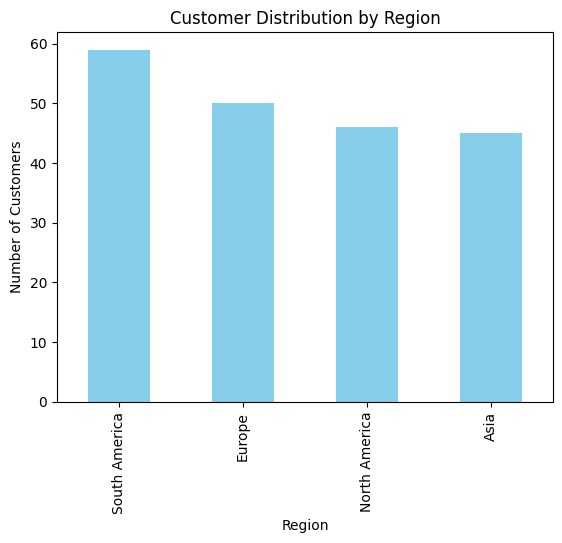

In [7]:
region_counts = customers['Region'].value_counts()
region_counts.plot(kind='bar', color='skyblue', title='Customer Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.show()

# 3. Top-selling products

In [8]:
top_products = transactions.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products = top_products.reset_index().merge(products, on='ProductID')
print("Top-Selling Products:")
print(top_products[['ProductName', 'Quantity']])


Top-Selling Products:
             ProductName  Quantity
0        SoundWave Jeans        46
1     SoundWave Cookbook        46
2     TechPro Headphones        45
3         ActiveWear Rug        43
4    HomeSense Desk Lamp        43
5  ActiveWear Smartphone        43
6       TechPro Cookbook        43
7        HomeSense Novel        39
8      ActiveWear Jacket        38
9    HomeSense Desk Lamp        38


# 4. Monthly revenue trends

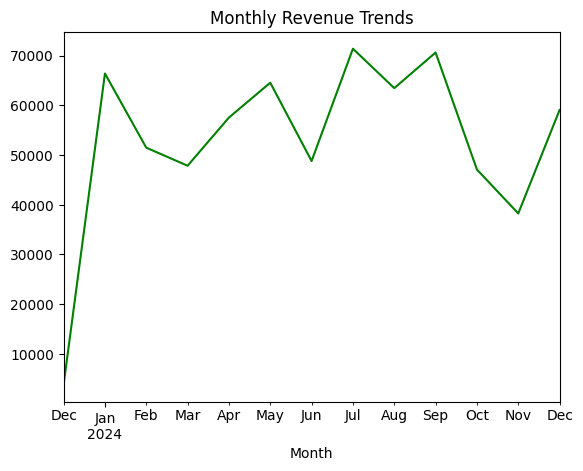

In [12]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Month'] = transactions['TransactionDate'].dt.to_period('M')
monthly_revenue = transactions.groupby('Month')['TotalValue'].sum()
monthly_revenue.plot(kind='line', title='Monthly Revenue Trends', color='green')
plt.show()

# 5. Customer spending analysis


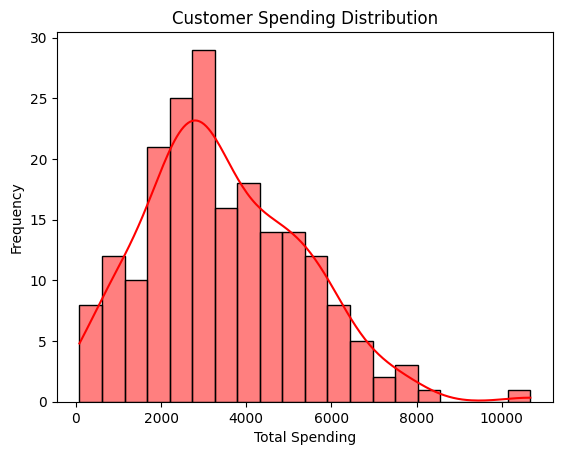

In [13]:
customer_spending = transactions.groupby('CustomerID')['TotalValue'].sum()
sns.histplot(customer_spending, bins=20, kde=True, color='red')
plt.title('Customer Spending Distribution')
plt.xlabel('Total Spending')
plt.ylabel('Frequency')
plt.show()

# Product category analysis

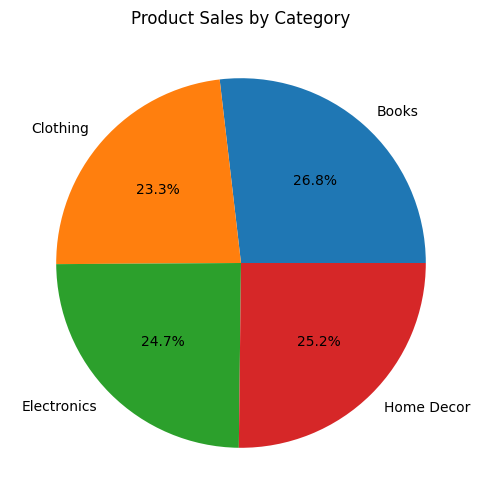

In [14]:
category_sales = transactions.merge(products, on='ProductID').groupby('Category')['Quantity'].sum()
category_sales.plot(kind='pie', autopct='%1.1f%%', title='Product Sales by Category', figsize=(6, 6))
plt.ylabel('')
plt.show()

# Task 2: Lookalike Model

In [15]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [17]:
# Data preparation: Merge datasets
data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')


customer_features = data.groupby('CustomerID').agg({'TotalValue': 'sum','Quantity': 'sum',
    'ProductID': lambda x: x.nunique(),  # Number of unique products purchased
    'Region': 'first'
}).reset_index()





# Encode categorical data (Region)
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(['CustomerID'], axis=1))

# Compute similarity matrix
similarity_matrix = cosine_similarity(scaled_features)

In [18]:
# Create the "Lookalike.csv" file for the first 20 customers
lookalike_results = {}
for idx, customer_id in enumerate(customer_features['CustomerID'][:20]):
    similar_indices = similarity_matrix[idx].argsort()[::-1][1:4]  # Top 3 similar customers
    similar_scores = similarity_matrix[idx][similar_indices]
    similar_customers = customer_features.iloc[similar_indices]['CustomerID']
    lookalike_results[customer_id] = list(zip(similar_customers, similar_scores))

# Save to CSV
lookalike_df = pd.DataFrame([
    {'CustomerID': cust_id, 'Lookalikes': lookalikes}
    for cust_id, lookalikes in lookalike_results.items()
])
lookalike_df.to_csv('Lookalike.csv', index=False)

# Display the results for demonstration
print(lookalike_df)

   CustomerID                                         Lookalikes
0       C0001  [(C0107, 0.9964188681403604), (C0137, 0.995703...
1       C0002  [(C0142, 0.9886959575423099), (C0177, 0.965928...
2       C0003  [(C0133, 0.9635611953572196), (C0190, 0.963289...
3       C0004  [(C0113, 0.9882712920700519), (C0102, 0.971863...
4       C0005  [(C0186, 0.9974830562219872), (C0159, 0.996961...
5       C0006  [(C0168, 0.9752016159018667), (C0048, 0.959616...
6       C0007  [(C0159, 0.9883906886698319), (C0005, 0.986743...
7       C0008  [(C0068, 0.9168824947017071), (C0098, 0.915164...
8       C0009  [(C0198, 0.9896003583528926), (C0063, 0.977546...
9       C0010  [(C0166, 0.9831076508104796), (C0199, 0.973381...
10      C0011  [(C0107, 0.9950672266034495), (C0048, 0.994949...
11      C0012  [(C0153, 0.9868558880228324), (C0169, 0.983478...
12      C0013  [(C0155, 0.9922219531277349), (C0102, 0.987075...
13      C0014  [(C0060, 0.9995245754006837), (C0198, 0.993303...
14      C0015  [(C0020, 0

 # Task 3: Customer Segmentation / Clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


# Data preparation (reuse customer_features from Task 2)
features = customer_features.drop(['CustomerID'], axis=1)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(features)

In [20]:
# Evaluate clusters with Davies-Bouldin Index
db_index = davies_bouldin_score(features, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.5495242661346638


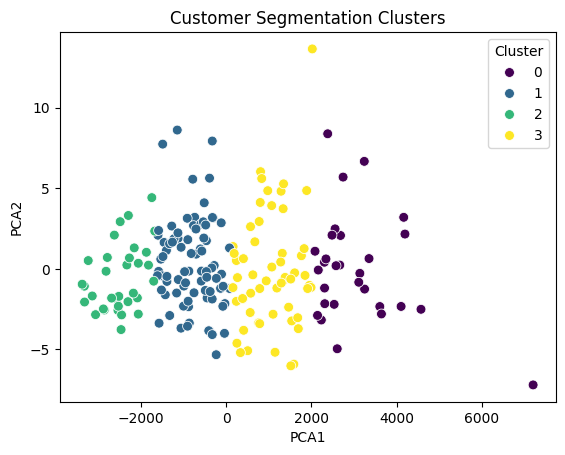

In [24]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
customer_features['PCA1'] = reduced_features[:, 0]
customer_features['PCA2'] = reduced_features[:, 1]

sns.scatterplot(
    data=customer_features,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    s=50
)
plt.title('Customer Segmentation Clusters')
plt.show()
